# Prepare SpaceNet 7 Data for Model Training

We assume that initial steps of README have been executed and that this notebook is running in a docker container.  See the `src` directory for functions used in the algorithm.  

In [1]:
# Dataset location (edit as needed)
root_dir = '/home/phone/Desktop/CS437/Project/CosmiQ_SN7_Baseline/local_data/sn7/aws_download/'

In [2]:
import multiprocessing
import pandas as pd
import numpy as np
import skimage
import gdal
import sys
import os

import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
mpl.rcParams['figure.dpi'] = 300

import solaris as sol
from solaris.raster.image import create_multiband_geotiff
from solaris.utils.core import _check_gdf_load

# import from data_prep_funcs
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from sn7_baseline_prep_funcs import map_wrapper, make_geojsons_and_masks

/home/phone/miniconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/phone/miniconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/phone/miniconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/phone/miniconda3/envs/solaris/lib/pyt

In [5]:
import math

In [7]:
aois = sorted([f for f in os.listdir(os.path.join(root_dir, 'train'))
               if os.path.isdir(os.path.join(root_dir, 'train', f))])

print(f'Before truncating dataset, Aoi count : {len(aois)}')

# using this variable to control how many of the 60 AoIs we will be using (only doing this to reduce dataset)
truncate_ratio = 0.4
truncate_amt = math.ceil(truncate_ratio * len(aois))
aois = aois[:truncate_amt]

print(f'After truncating dataset, Aoi count : {len(aois)}')


Before truncating dataset, Aoi count : 48
After truncating dataset, Aoi count : 20


In [34]:
n_threads = 10
params = [] 
make_fbc = False

input_args = []
total_images_used = 0

for i, aoi in enumerate(aois):
    print(i, "aoi : ", aoi)
    im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked/')
    total_images_used += (len(os.listdir(im_dir)))
    json_dir = os.path.join(root_dir, 'train', aoi, 'labels_match/')
    out_dir_mask = os.path.join(root_dir, 'train', aoi, 'masks/')
    out_dir_mask_fbc = os.path.join(root_dir, 'train', aoi, 'masks_fbc/')
    os.makedirs(out_dir_mask, exist_ok=True)
    if make_fbc:
        os.makedirs(out_dir_mask_fbc, exist_ok=True)

    json_files = sorted([f
                for f in os.listdir(os.path.join(json_dir))
                if f.endswith('Buildings.geojson') and os.path.exists(os.path.join(json_dir, f))])
    for j, f in enumerate(json_files):
        # print(i, j, f)
        name_root = f.split('.')[0]
        json_path = os.path.join(json_dir, f)
        image_path = os.path.join(im_dir, name_root + '.tif').replace('labels', 'images').replace('_Buildings', '')
        output_path_mask = os.path.join(out_dir_mask, name_root + '.tif')
        if make_fbc:
            output_path_mask_fbc = os.path.join(out_dir_mask_fbc, name_root + '.tif')
        else:
            output_path_mask_fbc = None
            
        if (os.path.exists(output_path_mask)):
             continue
        else: 
            input_args.append([make_geojsons_and_masks, 
                               name_root, image_path, json_path,
                               output_path_mask, output_path_mask_fbc])

# execute 
print("len input_args", len(input_args))
print("Execute...\n")
with multiprocessing.Pool(n_threads) as pool:
    pool.map(map_wrapper, input_args)

print(f'Total Images used pre-processed were : {total_images_used}')

0 aoi :  L15-0331E-1257N_1327_3160_13
1 aoi :  L15-0357E-1223N_1429_3296_13
2 aoi :  L15-0358E-1220N_1433_3310_13
3 aoi :  L15-0361E-1300N_1446_2989_13
4 aoi :  L15-0368E-1245N_1474_3210_13
5 aoi :  L15-0387E-1276N_1549_3087_13
6 aoi :  L15-0434E-1218N_1736_3318_13
7 aoi :  L15-0457E-1135N_1831_3648_13
8 aoi :  L15-0487E-1246N_1950_3207_13
9 aoi :  L15-0506E-1204N_2027_3374_13
10 aoi :  L15-0544E-1228N_2176_3279_13
11 aoi :  L15-0566E-1185N_2265_3451_13
12 aoi :  L15-0571E-1075N_2287_3888_13
13 aoi :  L15-0577E-1243N_2309_3217_13
14 aoi :  L15-0586E-1127N_2345_3680_13
15 aoi :  L15-0595E-1278N_2383_3079_13
16 aoi :  L15-0614E-0946N_2459_4406_13
17 aoi :  L15-0632E-0892N_2528_4620_13
18 aoi :  L15-0683E-1006N_2732_4164_13
19 aoi :  L15-0760E-0887N_3041_4643_13
20 aoi :  L15-0924E-1108N_3699_3757_13
21 aoi :  L15-0977E-1187N_3911_3441_13
22 aoi :  L15-1014E-1375N_4056_2688_13
23 aoi :  L15-1015E-1062N_4061_3941_13
len input_args 0
Execute...

Total Images used pre-processed were : 561


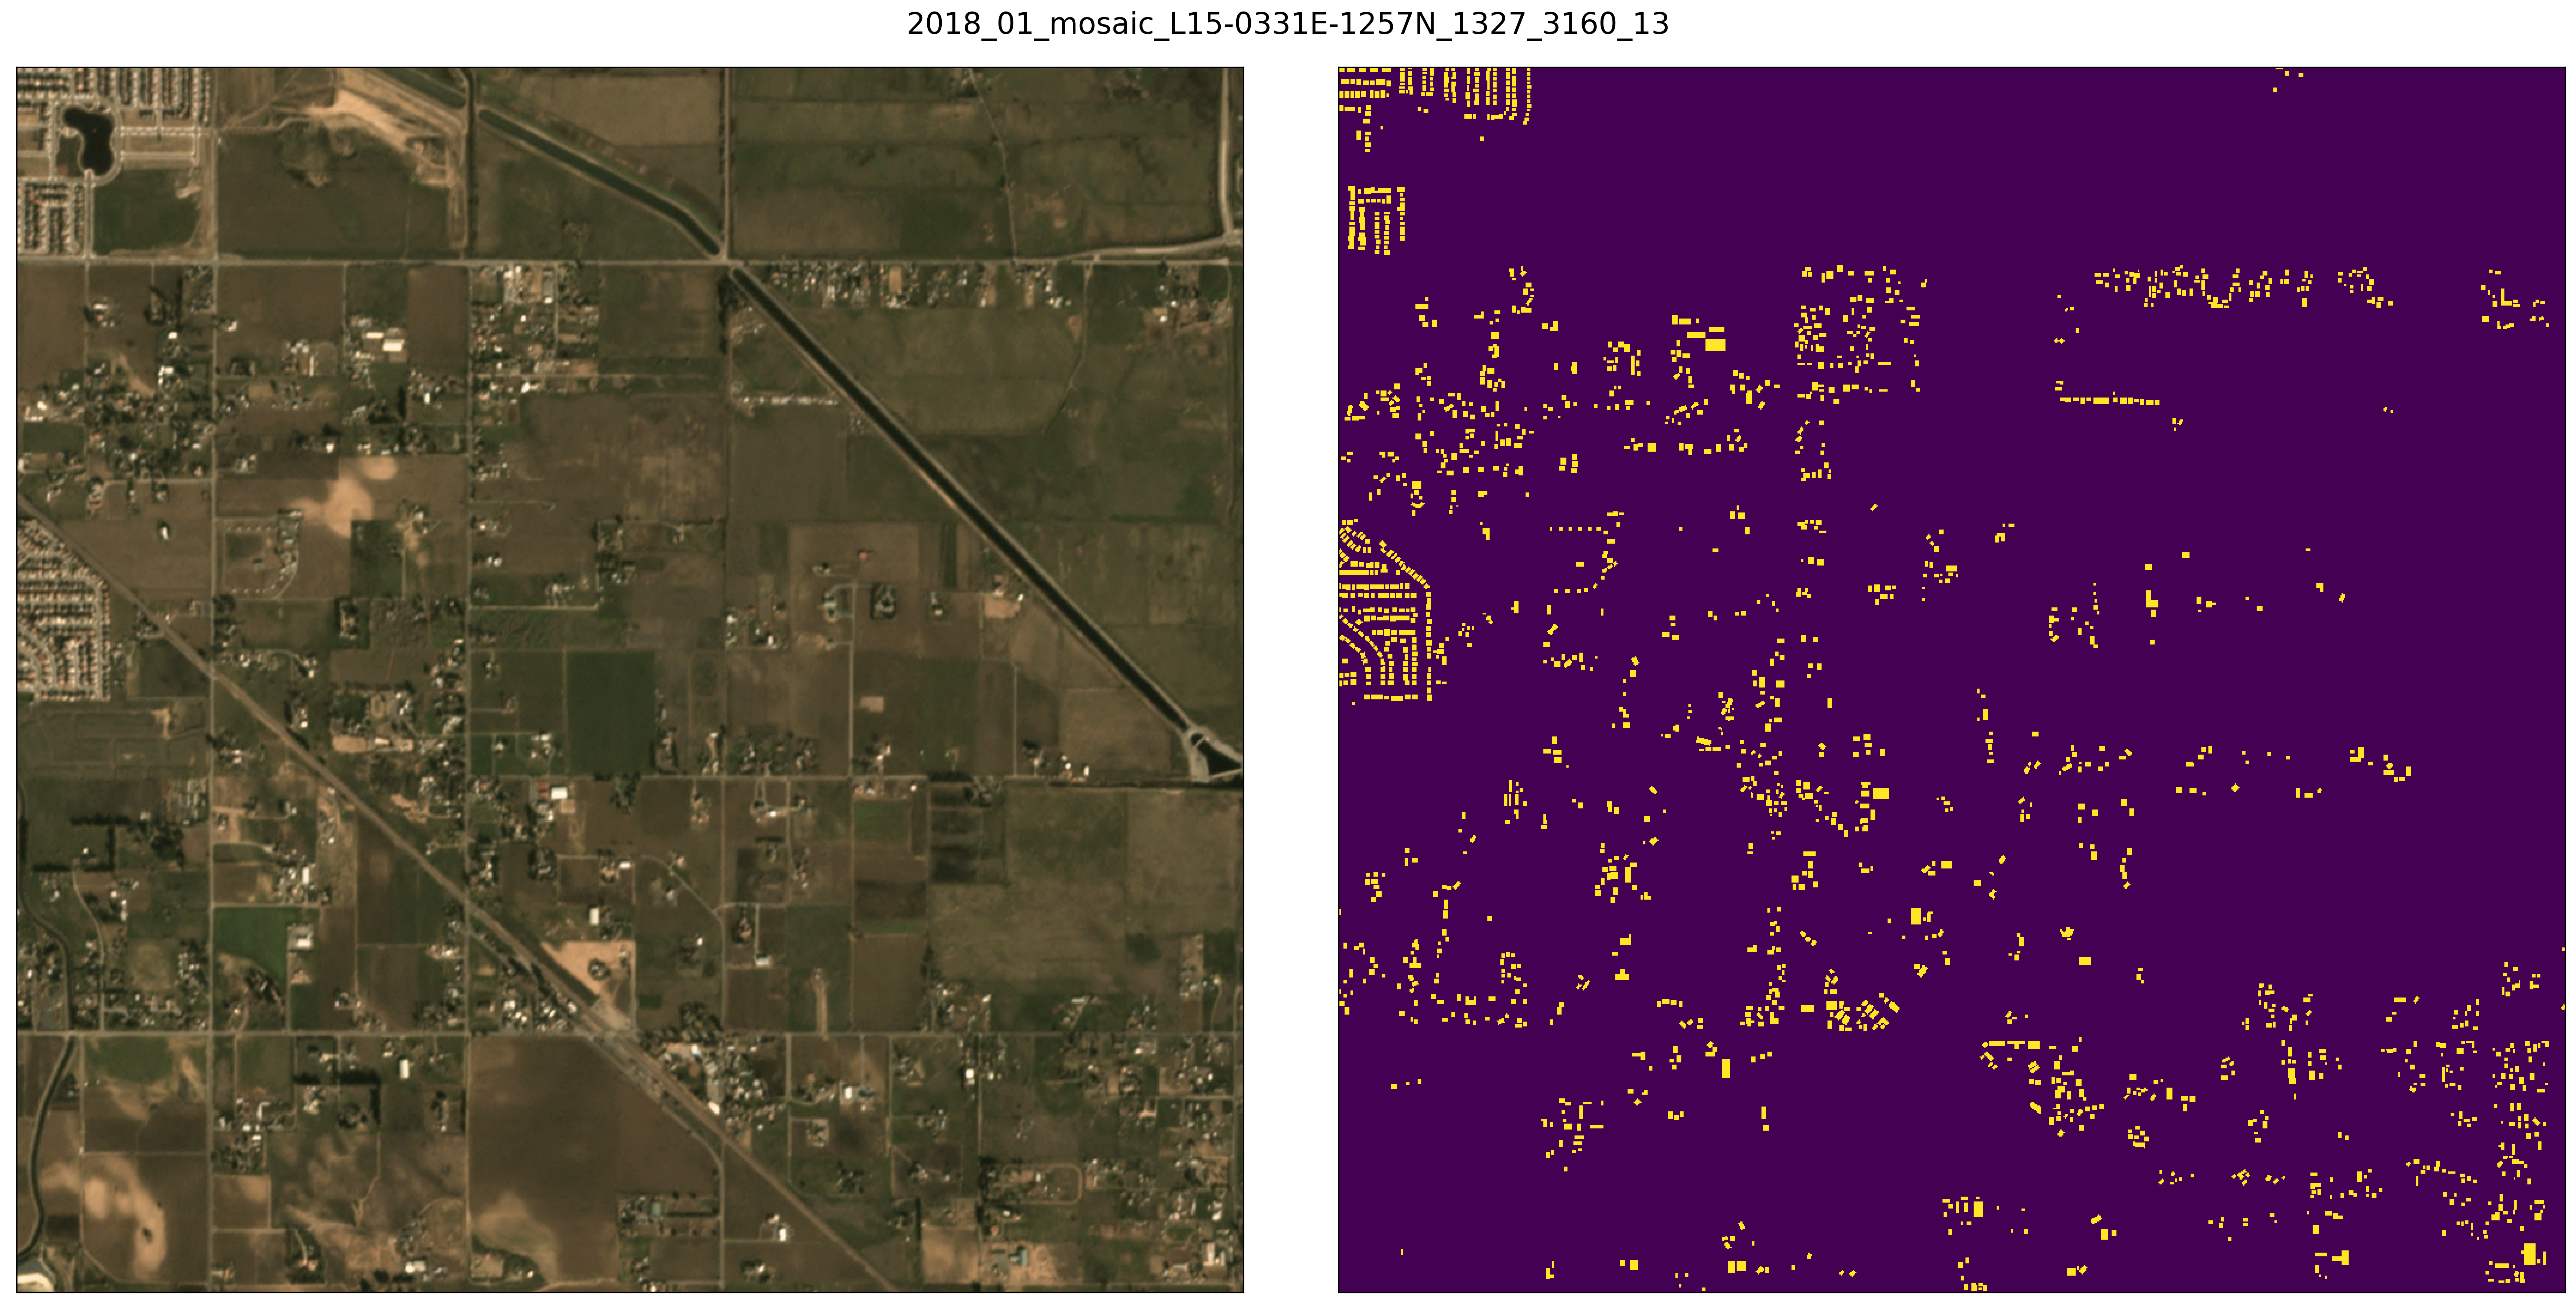

In [23]:
# Inspect visually

aoi = 'L15-0331E-1257N_1327_3160_13'
im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked')
mask_dir = os.path.join(root_dir, 'train', aoi, 'masks')

im_list = sorted([z for z in os.listdir(im_dir) if z.endswith('.tif')])
im_file = im_list[0]

im_path = os.path.join(im_dir, im_file)
mask_path = os.path.join(mask_dir, im_file.split('.')[0] + '_Buildings.tif')
im = skimage.io.imread(im_path)
mask = skimage.io.imread(mask_path)

figsize=(24, 12)
name = im_file.split('.')[0].split('global_monthly_')[-1]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(im)
ax0.set_xticks([])
ax0.set_yticks([])
# _ = ax0.set_title(name)
_ = ax1.imshow(mask)
ax1.set_xticks([])
ax1.set_yticks([])
# _ = ax1.set_title(name)
_ = fig.suptitle(name)
plt.tight_layout()

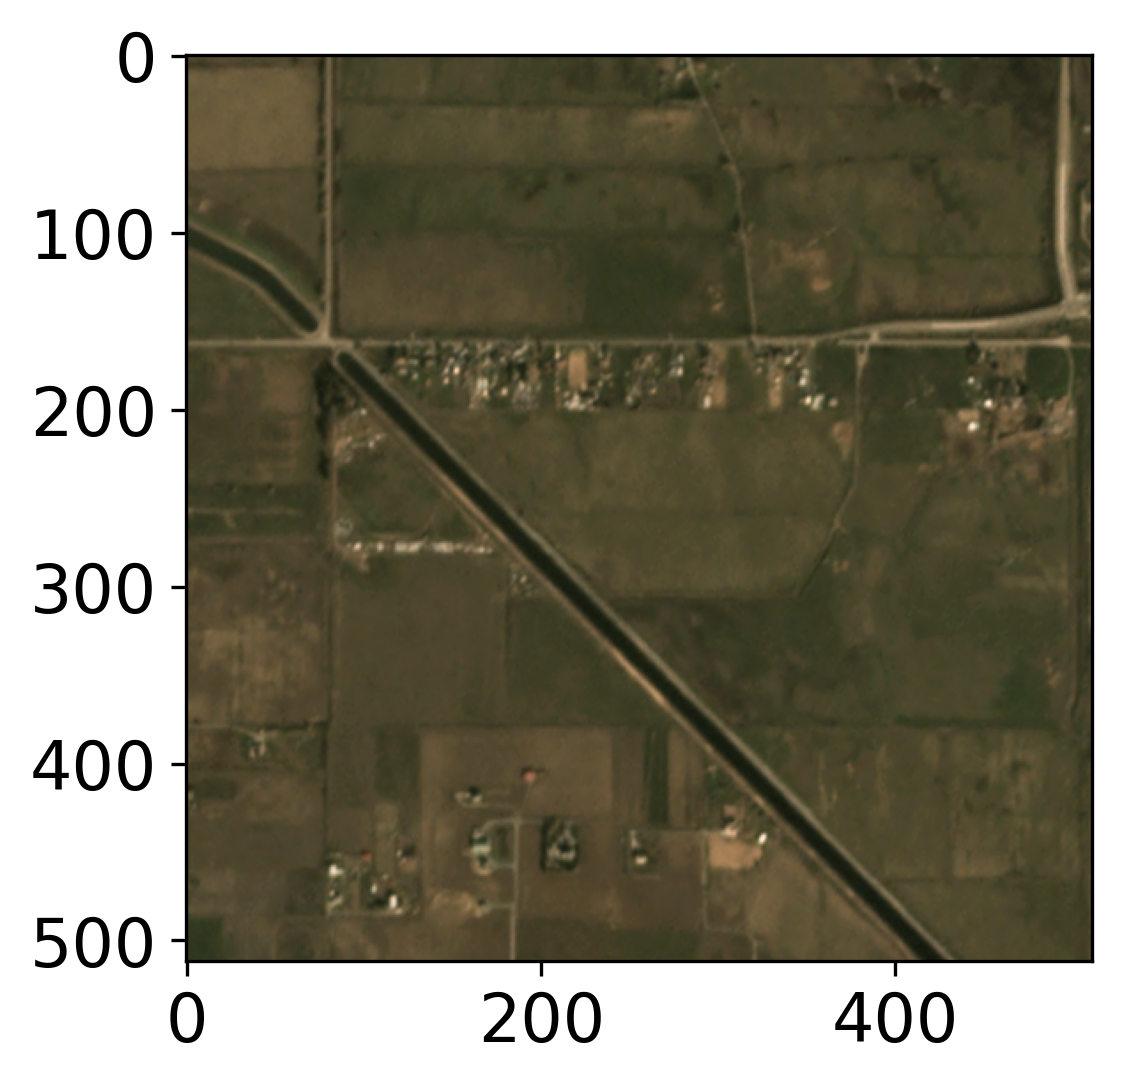

In [52]:
image=  im

x= 512
y= 0

h = 512
w = 512

crop = image[y:y+h, x:x+w]
plt.imshow(crop)

In [8]:
# Make dataframe csvs for train/test

out_dir = os.path.join(root_dir, 'csvs/')
pops = ['train', 'test_public']



os.makedirs(out_dir, exist_ok=True)

# Dictates how much of the present dataset we want to use (reducing size due to machine constraints)
# truncate_ratio = 1.0, use entire dataset
# truncate_ratio = 0.4, use 40% of the present images/dataset

truncate_ratio = 0.4

sum_subdirs = 0
for pop in pops: 
#     d is two main directories : train and test
    d = os.path.join(root_dir, pop)
    truncate_amt = math.ceil(truncate_ratio * len(os.listdir(d)))
#     print(len(os.listdir(d)[:truncate_amt]))
    
    outpath = os.path.join(out_dir, 'sn7_baseline_' + pop + '_df.csv')
    im_list, mask_list = [], []
#     print(d)
    subdirs = sorted([f for f in os.listdir(d)[:truncate_amt] if os.path.isdir(os.path.join(d, f))])
    sum_subdirs += len(subdirs)
    
    for subdir in subdirs:
        
        if pop == 'train':
            im_files = [os.path.join(d, subdir, 'images_masked', f)
                    for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                    if f.endswith('.tif') and os.path.exists(os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif'))]
            mask_files = [os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif')
                      for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                      if f.endswith('.tif') and os.path.exists(os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif'))]
            im_list.extend(im_files)
            mask_list.extend(mask_files)
    
        elif pop == 'test_public':
            im_files = [os.path.join(d, subdir, 'images_masked', f)
                    for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                    if f.endswith('.tif')]
            im_list.extend(im_files)

    # save to dataframes
    # print("im_list:", im_list)
    # print("mask_list:", mask_list)
    if pop == 'train':
        df = pd.DataFrame({'image': im_list, 'label': mask_list})
        display(df.head())
    elif pop == 'test_public':
        df = pd.DataFrame({'image': im_list})
    df.to_csv(outpath, index=False)
    print(pop, "len df:", len(df))
    print("output csv:", outpath)



image  \
0  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...   
1  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...   
2  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...   
3  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...   
4  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...   

                                               label  
0  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...  
1  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...  
2  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...  
3  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...  
4  /home/phone/Desktop/CS437/Project/CosmiQ_SN7_B...

train len df: 479
output csv: /home/phone/Desktop/CS437/Project/CosmiQ_SN7_Baseline/local_data/sn7/aws_download/csvs/sn7_baseline_train_df.csv
test_public len df: 120
output csv: /home/phone/Desktop/CS437/Project/CosmiQ_SN7_Baseline/local_data/sn7/aws_download/csvs/sn7_baseline_test_public_df.csv
